In [11]:
from flask import Flask, request, jsonify, render_template
from utils.utils import *
from refinement_agent.refinement import refinement_agent
from verification_agent.main import get_verification_result
from selection_agent.selection_agent_v3 import find_best_plan
import re
from openai import OpenAI
from dotenv import load_dotenv
import os

# Load environment variables
load_dotenv()
client = OpenAI(api_key=os.getenv('OPENAI_API_KEY'))

def extract_scores(output_text):
    satisfaction_match = re.search(r"User Satisfaction Rate: (\d+)", output_text)
    realism_match = re.search(r"Trip Realism Score: (\d+)", output_text)

    satisfaction_rate = int(satisfaction_match.group(1)) if satisfaction_match else None
    realism_score = int(realism_match.group(1)) if realism_match else None

    return satisfaction_rate, realism_score

def process_query_for_score(user_query, conversation_id):
    print(f"$$$$$$$$$ Saving User Query for conversation {conversation_id} $$$$$$$$")
    save_user_query(conversation_id, user_query)

    # step 2: select best-matched trip plan
    selected_trip_plan = find_best_plan(user_query)
    print(f"$$$$$$$$$ Saving Selected Trip for conversation {conversation_id} $$$$$$$$")
    save_selected_trip(conversation_id, selected_trip_plan)

    # step 3: refined selected_trip_plan
    refined_trip_plan = refinement_agent(user_query, selected_trip_plan)
    print(f"$$$$$$$$$ Saving Refined Trip for conversation {conversation_id} $$$$$$$$")
    save_refined_trip(conversation_id, refined_trip_plan)

    # step 4: verify selected_trip_plan
    selected_result = get_verification_result(client, user_query, selected_trip_plan)
    selected_user_satisfaction_rate, selected_trip_realism_score = extract_scores(selected_result)
    if selected_user_satisfaction_rate is None or selected_trip_realism_score is None:
        print("Error extracting scores from selected_result")
    print(f"$$$$$$$$$ Saving Verification Result for conversation {conversation_id} $$$$$$$$")
    save_verification_result(conversation_id, selected_result, "selected_verification")

    # step 5: verify refined_trip_plan
    refined_result = get_verification_result(client, user_query, refined_trip_plan)
    refined_user_satisfaction_rate, refined_trip_realism_score = extract_scores(refined_result)
    if refined_user_satisfaction_rate is None or refined_trip_realism_score is None:
        print("Error extracting scores from refined_result")
    print(f"$$$$$$$$$ Saving Refined Verification Result for conversation {conversation_id} $$$$$$$$")
    save_verification_result(conversation_id, refined_result, "refined_verification")

    refined_score = (refined_user_satisfaction_rate * 0.8) + (refined_trip_realism_score * 0.2)
    selected_score = (selected_user_satisfaction_rate * 0.8) + (selected_trip_realism_score * 0.2)

    return refined_score, selected_score

In [32]:
import itertools
import random
import pandas as pd

candidate_destination_country = ["Iceland", "Norway", "Italy", "China", "Japan", "South Korea"]
candidate_duration = [1, 3, 5, 7, 10]
candidate_budget = [300, 500, 1000, 5000, 10000]
NUM_OF_EXAMPLE = 1
# Generate all possible combinations
all_combinations = list(itertools.product(candidate_duration, candidate_destination_country, candidate_budget))

# Select 20 unique combinations randomly
random.seed(42)
selected_combinations = random.sample(all_combinations, NUM_OF_EXAMPLE)

user_queries = [
    f"I want a {days}-day trip to {destination} with the budget of {budget}."
    for days, destination, budget in selected_combinations
]

# new_user_queries = [
#     "I want a 5-day trip to Iceland with the budget of 1675",
#     "I want a 3-day trip to Iceland with the budget of 330",
#     "I want a 7-day trip to Norway with the budget of 5066",
#     "I want a 17-day trip to Norway with the budget of 4586",
#     "I want a 14-day trip to Ireland with the budget of 1708",
#     "I want a 5-day trip to Ireland with the budget of 1205",
#     "I want a 8-day trip to Scotland with the budget of 2944",
#     "I want a 10-day trip to Scotland with the budget of 3321",
#     "I want a 8-day trip to Sweden with the budget of 1705"
# ]

new_user_queries = [
    "I want a 7-day trip to Italy with the budget of 2500"
]

converation_ids = [f"conversation_{i+31}" for i in range(0, NUM_OF_EXAMPLE)]

df = pd.DataFrame(columns=["user query", "refined score", "selected score"])
for i in range(NUM_OF_EXAMPLE):
    print(f"+++++++++ Example {i+1} ++++++++++++")
    query = new_user_queries[i]
    conversation_id = converation_ids[i]
    try:
        refined_score, selected_score = process_query_for_score(query, conversation_id)
    except TypeError as e:
        print(f"❌ ERROR: {e}")
        continue
    df.loc[len(df)] = [query, refined_score, selected_score]
    print(f"{conversation_id} || refined score: {round(refined_score, 0)} || selected_score: {round(selected_score, 0)}")

df.to_csv("results/20_results_without_baseline_score.csv", index=False)


+++++++++ Example 1 ++++++++++++
$$$$$$$$$ Saving User Query for conversation conversation_31 $$$$$$$$
user_query saved successfully to TripPlanState.json
{'country': 'Italy', 'destination': None, 'budget': 2500, 'duration': 7, 'points_of_interest': None}
$$$$$$$$$ Saving Selected Trip for conversation conversation_31 $$$$$$$$
selected_trip saved successfully to TripPlanState.json
$$$$$$$$$ Saving Refined Trip for conversation conversation_31 $$$$$$$$
refined_trip saved successfully to TripPlanState.json
$$$$$$$$$ Saving Verification Result for conversation conversation_31 $$$$$$$$
selected_verification saved successfully to TripPlanState.json
$$$$$$$$$ Saving Refined Verification Result for conversation conversation_31 $$$$$$$$
refined_verification saved successfully to TripPlanState.json
conversation_31 || refined score: 97.0 || selected_score: 98.0


In [33]:
baseline_model_df = pd.read_csv("results/20_baseline_model_score.csv", header=0)
df = pd.read_csv("results/20_results_without_baseline_score.csv", header=0)
baseline_model_df['baseline score'] = (baseline_model_df['satisfaction rate'] * 0.8) + (baseline_model_df['realism score'] * 0.2)
df['baseline score'] = baseline_model_df['baseline score']
df.to_csv("results/20_results_with_baseline_score.csv", index=False)
df

,user query,refined score,selected score,baseline score
0,I want a 1-day trip to South Korea with the bu...,94.0,41.4,68.0
1,I want a 5-day trip to Iceland with the budget...,97.0,48.0,64.0
2,I want a 1-day trip to South Korea with the bu...,98.0,56.0,60.0
3,I want a 10-day trip to China with the budget ...,97.0,56.0,90.0
4,I want a 1-day trip to Japan with the budget o...,98.0,16.0,62.0
5,I want a 7-day trip to China with the budget o...,98.0,65.0,26.0
6,I want a 1-day trip to Norway with the budget ...,98.0,26.4,80.0
7,I want a 3-day trip to South Korea with the bu...,98.0,94.0,80.0
8,I want a 10-day trip to Norway with the budget...,97.0,81.0,88.0
9,I want a 10-day trip to Japan with the budget ...,98.0,94.0,94.0


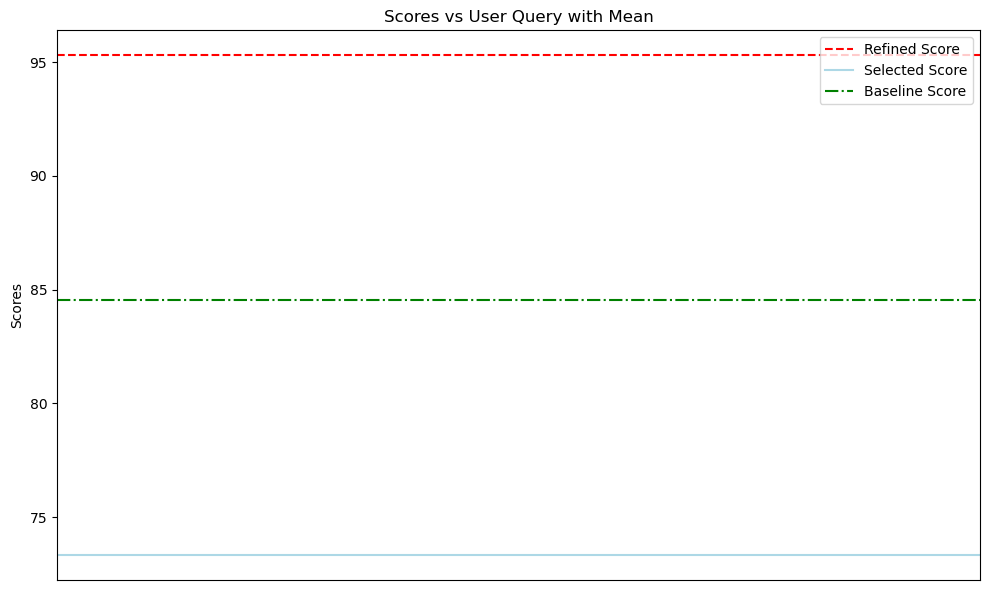

In [53]:
import matplotlib.pyplot as plt
df['user_query'] = [f"user query {i+1}" for i in range(len(df))]
mean_scores = df[['refined score', 'selected score', 'baseline score']].mean(axis=0)

# Plotting
plt.figure(figsize=(10, 6))

# # Plot each score column
# plt.plot(df['user_query'], df['refined score'], label='Refined Score', marker='o')
# plt.plot(df['user_query'], df['selected score'], label='Selected Score', marker='o')
# plt.plot(df['user_query'], df['baseline score'], label='Baseline Score', marker='o')

# Plot the mean score
# for col, mean in mean_scores.items():
#     plt.axhline(y=mean, linestyle='--', label=f'{col} Mean ({mean:.2f})')
plt.axhline(mean_scores['refined score'], label='Refined Score', linestyle='--', color='red')
plt.axhline(mean_scores['selected score'], label='Selected Score', linestyle='solid', color='lightblue')
plt.axhline(mean_scores['baseline score'], label='Baseline Score', linestyle='dashdot', color='green')
# Add labels, title, and legend
# plt.xlabel('User Query')
plt.gca().axes.get_xaxis().set_visible(False)
plt.ylabel('Scores')
plt.title('Scores vs User Query with Mean')
# plt.xticks(rotation=45)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


In [42]:
mean_scores = df[['refined score', 'selected score', 'baseline score']].mean(axis=0)
mean_scores

refined score     95.30
selected score    73.34
baseline score    84.55
dtype: float64

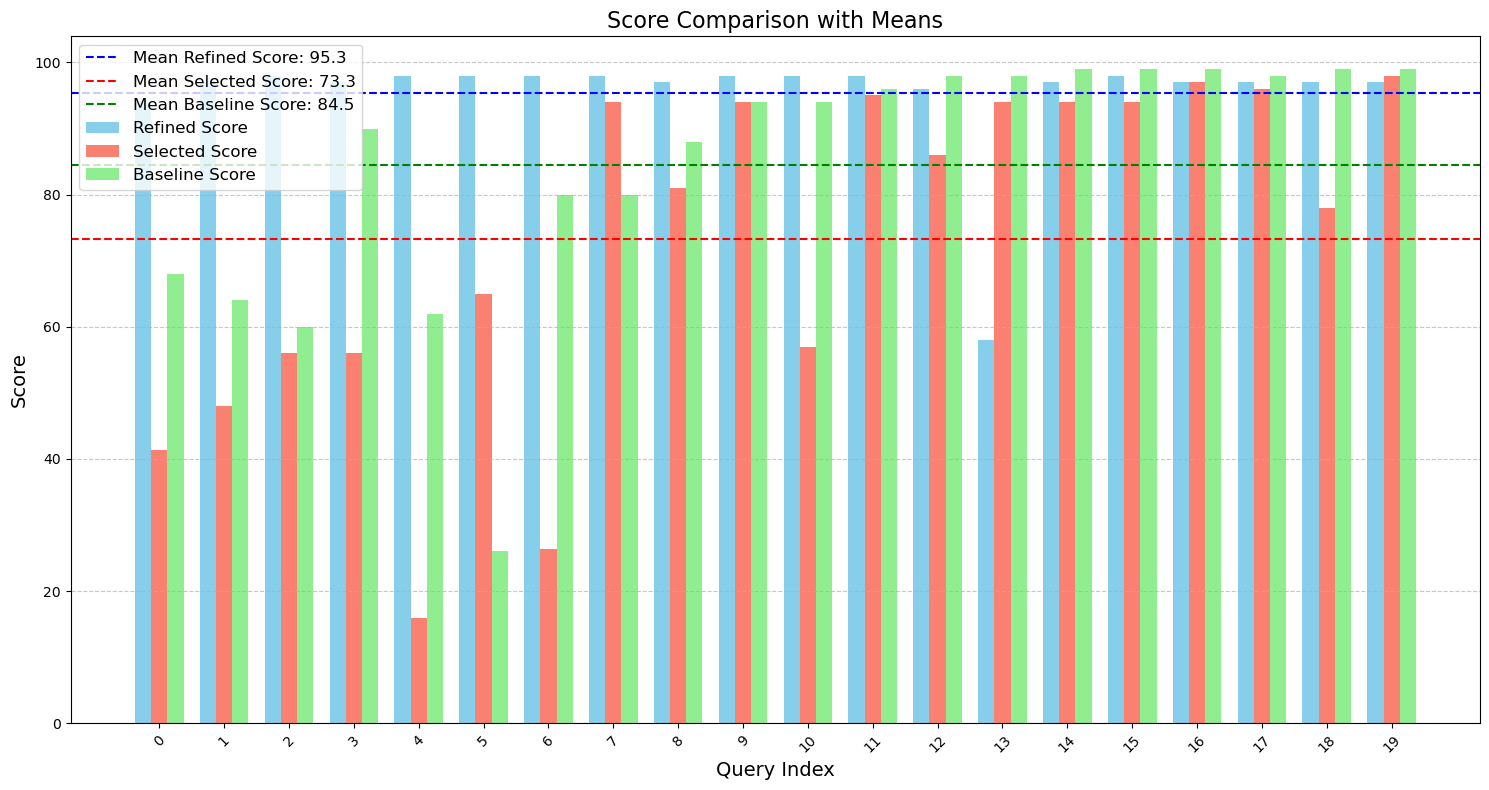

In [7]:
# Visualize the data using a grouped bar chart
x = np.arange(len(df))  # the label locations
width = 0.25  # the width of the bars

plt.figure(figsize=(15, 8))

# Plotting each score as a separate bar group
plt.bar(x - width, df["refined score"], width, label="Refined Score", color='skyblue')
plt.bar(x, df["selected score"], width, label="Selected Score", color='salmon')
plt.bar(x + width, df["baseline score"], width, label="Baseline Score", color='lightgreen')

# Calculate means for each score
mean_refined = df["refined score"].mean()
mean_selected = df["selected score"].mean()
mean_baseline = df["baseline score"].mean()

# Add horizontal lines for means
plt.axhline(mean_refined, color='blue', linestyle='--', linewidth=1.5, label=f"Mean Refined Score: {mean_refined:.1f}")
plt.axhline(mean_selected, color='red', linestyle='--', linewidth=1.5, label=f"Mean Selected Score: {mean_selected:.1f}")
plt.axhline(mean_baseline, color='green', linestyle='--', linewidth=1.5, label=f"Mean Baseline Score: {mean_baseline:.1f}")

# Add labels, title, and legend
plt.title("Score Comparison with Means", fontsize=16)
plt.xlabel("Query Index", fontsize=14)
plt.ylabel("Score", fontsize=14)
plt.xticks(x, df.index, rotation=45)  # Use indices as x-ticks
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


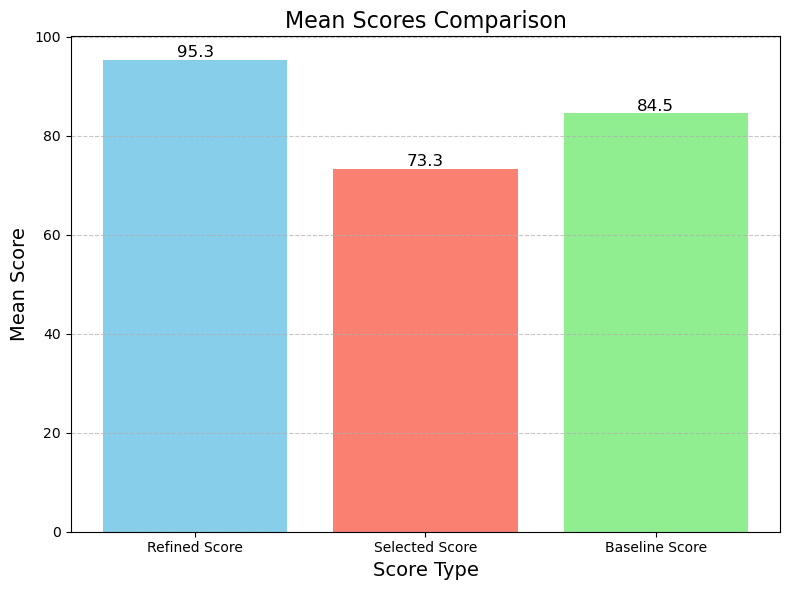

In [8]:
import matplotlib.pyplot as plt

# Calculate the means
mean_scores = {
    "Refined Score": df["refined score"].mean(),
    "Selected Score": df["selected score"].mean(),
    "Baseline Score": df["baseline score"].mean()
}

# Bar graph for the mean scores
plt.figure(figsize=(8, 6))
plt.bar(mean_scores.keys(), mean_scores.values(), color=["skyblue", "salmon", "lightgreen"])

# Add labels, title, and annotations
plt.title("Mean Scores Comparison", fontsize=16)
plt.ylabel("Mean Score", fontsize=14)
plt.xlabel("Score Type", fontsize=14)
for i, v in enumerate(mean_scores.values()):
    plt.text(i, v + 0.5, f"{v:.1f}", ha='center', fontsize=12)  # Annotate the bars with their values

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
